In [1]:
import numpy as np
import cmath
import scqubits as scq
import matplotlib.pyplot as plt

import chencrafts.toolbox as tb
import chencrafts.cqed as cqed

import qutip as qt

from fluxonium_tunable_coupler import FluxoniumTunableCouplerGrounded, ConstructFullPulse

scq.settings.PROGRESSBAR_DISABLED = True
import chencrafts
chencrafts.settings.PROGRESSBAR_DISABLED = True


In [ ]:
J_eff_total

## system

In [2]:
def FTC_system(
    E_Ja, E_Jb, 
    E_Ca, E_Cb, 
    E_La, E_Lb,
    E_C, ECm, E_L1, E_L2, E_J,
    flux_a, flux_b, flux_c, 
    **kwargs
):
    FTC_grounded = FluxoniumTunableCouplerGrounded(
        EJa=E_Ja, EJb=E_Jb, EC_twoqubit=np.inf,
        ECq1=E_Ca, ECq2=E_Cb, ELa=E_La, ELb=E_Lb,
        flux_a=flux_a, flux_b=flux_b, flux_c=flux_c,
        fluxonium_cutoff=130, fluxonium_truncated_dim=6,
        ECc=E_C, ECm=ECm, EL1=E_L1, EL2=E_L2, EJC=E_J,
        fluxonium_minus_truncated_dim=3, h_o_truncated_dim=3
    )

    return FTC_grounded

In [3]:
para_exp = {
    'E_Ja': 5.645,
    'E_Jb': 4.85,
    'E_Ca': 0.952,
    'E_Cb': 0.9,
    'E_L1': 3.52,
    'E_J': 4.246,
    'E_C': 12,
    'ECm': 8,
    'E_L2': 3.52,
    'E_La': 0.292,
    'E_Lb': 0.287,
}

FTC_grounded = FTC_system(
    **para_exp,
    flux_a = 0.5476437503017441,
    flux_b = 0.452356249698256,
    flux_c = 0.3087156604583222,
)

In [5]:
# FTC_grounded.find_sweetspot_by_spectrum(
#     flux_c=None, mode="l1+l2+zz", ftol=1e-8, eps=1e-11, flux_c_bounds=(0.28, 0.32), run_num=10
# )

In [6]:
# FTC_grounded.find_sweetspot_by_hybr(
#     ftol = 1e-8,
#     gtol = 1e-8,
#     eps = 1e-11,
#     flux_s_bounds = [0.045, 0.05],
#     flux_c_bounds = [0.3, 0.31],
# )

In [7]:
dim = 4

(
    H_0_full, H_a_full, H_b_full, H_c_full 
) = FTC_grounded.operators_at_sweetspot(dim, FTC_grounded.flux_a - 0.5 , FTC_grounded.flux_b - 0.5,)

In [8]:
H_b_full

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 5.088969e-01  5.239120e-02 -4.833860e+00  5.225079e-02]
 [ 5.239120e-02  5.401724e-01 -2.521446e-03 -4.833922e+00]
 [-4.833860e+00 -2.521446e-03  5.547796e-01 -5.646608e-02]
 [ 5.225079e-02 -4.833922e+00 -5.646608e-02  5.230617e-01]]

In [9]:
H_c_full

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 7.050816 -0.022703  0.031419  0.358299]
 [-0.022703  7.038269  0.358696  0.031136]
 [ 0.031419  0.358696  7.050606 -0.024755]
 [ 0.358299  0.031136 -0.024755  7.039005]]

In [10]:
eigs = FTC_grounded.eigenvals()
eigs[1] + eigs[2] - eigs[3] - eigs[0]

-8.120731997962594e-08

In [11]:
# idealize the drive operator
# H_0_full = qt.Qobj(np.zeros((dim, dim)))
H_a_full = qt.Qobj(qt.tensor(qt.qeye(2), qt.sigmax())) * H_a_full[0, 1]
H_a_full.dims = [[dim], [dim]]
H_b_full = qt.Qobj(qt.tensor(qt.sigmax(), qt.qeye(2))) * H_b_full[0, 2]
H_b_full.dims = [[dim], [dim]]

## Tool

In [12]:
# calculate fidelities
def my_to_chi(q_oper):
    # based on Nielsen and Chuang ch. 8. I found the qutip function qpt to be unstable
    pauli_ops_oneq = [qt.qeye(2) / 2, qt.sigmax() / 2, 
                      qt.sigmay() / 2, qt.sigmaz() / 2]
    pauli_ops = [qt.tensor(pauli_op1, pauli_op2) for pauli_op1 in pauli_ops_oneq
                 for pauli_op2 in pauli_ops_oneq]
    kraus_ops = qt.to_kraus(q_oper, tol=1e-10)
    e_ij_coeffs = np.array([[np.trace(kraus_op.dag() * pauli_op)
                             for pauli_op in pauli_ops]
                            for kraus_op in kraus_ops] 
                          )
    return np.conjugate(e_ij_coeffs).T @ e_ij_coeffs

def calc_fidel_chi(chi_real, chi_ideal):
    return (4 * np.trace(chi_real @ chi_ideal) + np.trace(chi_real))/5
    # return (4 * np.trace(chi_real @ chi_ideal) + 1)/5
    # return np.trace(chi_real @ chi_ideal)

#### Understand chi

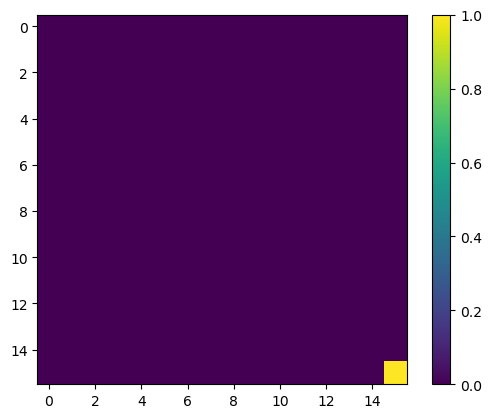

In [13]:
# test_op = qt.tensor(qt.sigmax().sqrtm(), qt.qeye(2))
test_op = qt.tensor(qt.qeye(2), qt.sigmaz())
test_op = qt.tensor(qt.sigmaz(), qt.sigmaz())
test_chi = my_to_chi(qt.sprepost(test_op, test_op.dag()))
plt.imshow(np.abs(test_chi))
plt.colorbar()
plt.show()

## Single qubit gate

In [14]:
import chencrafts as cc

In [65]:
def cost(
    params, which_qubit, 
    T1_a=np.inf, Tup_a=np.inf, Tphi_a=np.inf, 
    T1_b=np.inf, Tup_b=np.inf, Tphi_b=np.inf, 
    with_RWA=False,
    return_item='fidelity'
):

    target_phase_op = qt.tensor(
        (-1j * params.pop("target_phase_b") * qt.sigmaz() / 2).expm(),
        (-1j * params.pop("target_phase_a") * qt.sigmaz() / 2).expm(),
    )

    if which_qubit == 'a':
        omega_d = H_0_full[1, 1] * params.pop("freq_factor", 1.0)
        drive_oprt = H_a_full
        drive_mat_elem = H_a_full[0, 1]
        total_time = 83.3       # amp ~ 0.0082
        U_target = qt.tensor(qt.qeye(2),(-1 * qt.sigmax()).sqrtm())
        
    elif which_qubit == 'b':
        omega_d = H_0_full[2, 2] * params.pop("freq_factor", 1.0)
        drive_oprt = H_b_full
        drive_mat_elem = H_b_full[0, 2]
        total_time = 65.1       # amp ~ 0.0108
        U_target = qt.tensor((qt.sigmax()).sqrtm(), qt.qeye(2))
        
    else:
        raise ValueError("which_qubit should be 'a' or 'b'.")

    U_target = target_phase_op * U_target    # account for the phase accumulated naturally
    # U_target = target_phase_op.dag() * U_target * target_phase_op
    U_target_sp = qt.sprepost(U_target, U_target.dag())


    pulse = cqed.Gaussian(
        base_angular_freq = omega_d, 
        duration = total_time, 
        sigma = total_time / 4, 
        rotation_angle = np.pi / 2, 
        tgt_mat_elem = np.abs(drive_mat_elem),
        init_time = 0,
        init_phase = params["phase"],
        with_freq_shift = False,
    )
    pulse.drive_amp = params["amp"]


    y_pulse = cqed.Gaussian(
        base_angular_freq = omega_d, 
        duration = total_time, 
        sigma = total_time / 4, 
        rotation_angle = np.pi / 2, 
        tgt_mat_elem = np.abs(drive_mat_elem),
        init_time = 0,
        init_phase = params["phase"] + np.pi / 2,
        with_freq_shift = False,
    )
    y_pulse.drive_amp = params["y_amp"]
    drag_pulse = lambda t, *args: -y_pulse(t) * (t - y_pulse.t_mid) / y_pulse.sigma**2
    total_pulse = lambda t, *args: pulse(t) + drag_pulse(t)

    # if with_RWA:
        # pulse.exp_only = True
        # y_pulse.exp_only = True
        # drive_oprt = qt.Qobj(np.triu(drive_oprt.full()))
        # H = [
        #     H_0_full, 
        #     [drive_oprt, total_pulse], 
        #     [drive_oprt.dag(), lambda t, *args: total_pulse(t).conj()], 
        # ]

    if with_RWA:
        pulse.drive_freq = 0
        y_pulse.drive_freq = 0
        H = [
            [drive_oprt, total_pulse], 
        ]
    else:
        H = [H_0_full, [drive_oprt, total_pulse]]

    if return_item == "pulse":
        return total_pulse
    if return_item == "hamiltonian":
        return H

    gamma1_a = 1. / T1_a
    gammaup_a = 1. / Tup_a
    gammaphi_a = 1. / Tphi_a

    gamma1_b = 1. / T1_b
    gammaup_b = 1. / Tup_b
    gammaphi_b = 1. / Tphi_b

    state_00 = qt.basis(dim, 0)
    state_01 = qt.basis(dim, 2)
    state_10 = qt.basis(dim, 1)
    state_11 = qt.basis(dim, 3)

    sma = state_00 * state_10.dag() + state_01 * state_11.dag()
    smb = state_00 * state_01.dag() + state_10 * state_11.dag()
    sza = (state_00 * state_00.dag() + state_01 * state_01.dag() 
        - state_10 * state_10.dag() - state_11 * state_11.dag())
    szb = (state_00 * state_00.dag() - state_01 * state_01.dag() 
        + state_10 * state_10.dag() - state_11 * state_11.dag())
    c_ops = [
        np.sqrt(gamma1_a) * sma, 
        np.sqrt(gamma1_b) * smb, 
        np.sqrt(gammaup_a) * sma.dag(), 
        np.sqrt(gammaup_b) * smb.dag(), 
        np.sqrt(gammaphi_a / 2) * sza, 
        np.sqrt(gammaphi_b / 2) * szb,
    ]

    # simulate
    options = qt.Options(nsteps=10000)

    prop_list = qt.propagator(H, [0, total_time], options=options, c_op_list=c_ops)

    rot_frame = qt.propagator(H_0_full, [0, total_time], options=options)

    if return_item in ['fidelity', 'U_real', 'infidelity', 'qt_fidelity', 'qt_infidelity']:
        # fidelity calculation
        U_real = prop_list
        U_real.dims = [[[2, 2], [2, 2]], [[2, 2], [2, 2]]]

        # # phase cancellation
        # b_phase = cmath.phase(U_real[1, 1] / U_real[0, 0])
        # a_phase = cmath.phase(U_real[2, 2] / U_real[0, 0])

        # sigma_z_a = (1j * qt.tensor(qt.sigmaz(), qt.qeye(2)) * a_phase / 2).expm()
        # sigma_z_a_sp = qt.sprepost(sigma_z_a, sigma_z_a.dag())
        # sigma_z_b = (1j * qt.tensor(qt.qeye(2), qt.sigmaz()) * b_phase / 2).expm()
        # sigma_z_b_sp = qt.sprepost(sigma_z_b, sigma_z_b.dag())
        # sigma_z_b_dag_sp = qt.sprepost(sigma_z_b.dag(), sigma_z_b)


        # U_real = sigma_z_b_sp * U_real * sigma_z_b_dag_sp
        # U_real = sigma_z_a_sp * sigma_z_b_sp * U_real

        if return_item == 'U_real':
            return U_real

        if return_item == 'fidelity':
            chi_target = my_to_chi(U_target_sp)
            chi_real = my_to_chi(U_real)

            fid = calc_fidel_chi(chi_real, chi_target).real
            return fid
        elif return_item == 'infidelity':
            chi_target = my_to_chi(U_target_sp)
            chi_real = my_to_chi(U_real)

            fid = calc_fidel_chi(chi_real, chi_target).real
            return 1 - fid
        elif return_item == 'qt_fidelity':
            return qt.average_gate_fidelity(U_real, U_target)
        elif return_item == 'qt_infidelity':
            return 1 - qt.average_gate_fidelity(U_real, U_target)


    elif return_item == 'final_state':
        super_op = prop_list
        frame_op = qt.sprepost(rot_frame.dag(), rot_frame)
        init_state = qt.ket2dm(state_11)
        final_state = qt.vector_to_operator(frame_op * super_op * qt.operator_to_vector(init_state))

        return final_state
    else:
        raise ValueError("return_item should be 'fidelity' or 'final_state' or 'U_real'.")

In [79]:
opt = tb.Optimization(
    fixed_variables={},
    free_variable_ranges={
        # "amp": [0.008, 0.0085],     # qubit a
        "amp": [0.0105, 0.011],     # qubit b
        "y_amp": [-0.012, 0.012], 
        "freq_factor": [0.99, 1.01],
        "phase": [-np.pi, np.pi * 2],
        "target_phase_a": [-np.pi, np.pi * 2],
        "target_phase_b": [-np.pi, np.pi * 2],
    },   
    target_func=cost,
    target_kwargs={"which_qubit": 'b', "return_item": 'qt_infidelity',
                #    "T1_a": 360e3, "T1_b": 600e3, 
                #    "Tup_a": 360e3, "Tup_b": 600e3, 
                #    "Tphi_a": 820e3, "Tphi_b": 600e3,
                "with_RWA": False,
    },
    optimizer="L-BFGS-B",
    # optimizer="differential evolution",
    opt_options={
        "maxiter": 100, 
        "ftol": 1e-8, "gtol": 1e-8, 
        "eps": 1e-10, "maxls": 40,
        "disp": True},
)

opt.fix(
    freq_factor=1.0, 
    # phase=0.0,
    # target_phase_a=0.0,
    # target_phase_b=0.0,
    # y_amp=0.0
)

In [80]:
traj = opt.run()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.13455D-01    |proj g|=  3.23085D-01

At iterate    1    f=  1.40183D-01    |proj g|=  7.54884D-01

At iterate    2    f=  8.51991D-02    |proj g|=  7.09176D-01

At iterate    3    f=  8.00793D-03    |proj g|=  4.48515D-01

At iterate    4    f=  2.07623D-03    |proj g|=  2.47607D-01

At iterate    5    f=  1.29136D-04    |proj g|=  6.73961D-02

At iterate    6    f=  7.23012D-05    |proj g|=  2.77778D-03

At iterate    7    f=  7.22070D-05    |proj g|=  5.41789D-04

At iterate    8    f=  7.21914D-05    |proj g|=  4.29656D-04

At iterate    9    f=  6.79594D-05    |proj g|=  3.92131D-03

At iterate   10    f=  6.51064D-05    |proj g|=  2.24420D-02

At iterate   11    f=  5.59304D-05    |proj g|=  3.82916D-03

At iterate   12    f=  4.37517D-05    |proj g|=  5.38769D-02

At iterate   13    f=  2.5


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   16    f=  6.94375D-06    |proj g|=  3.62821D-03

At iterate   17    f=  6.91109D-06    |proj g|=  3.21965D-03

At iterate   18    f=  6.90410D-06    |proj g|=  2.60791D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     87     22     0     0   2.608D-03   6.904D-06
  F =   6.9040987377144702E-006

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [82]:
traj.final_full_para, traj.final_target

({'freq_factor': 1.0,
  'amp': 0.01077016494551103,
  'y_amp': 0.0015649437086851879,
  'phase': 3.1664877878942264,
  'target_phase_a': -0.9514247537769878,
  'target_phase_b': 6.112467448237851},
 6.90409873771447e-06)

In [60]:
cost(
    traj.final_full_para, 
    **{
        "which_qubit": 'a', "return_item": 'qt_infidelity',
        # "T1_a": 360e3, "T1_b": 600e3, 
        # "Tup_a": 360e3, "Tup_b": 600e3, 
        # "Tphi_a": 820e3, "Tphi_b": 600e3,
}) - cost(
    traj.final_full_para,
    **{
        "which_qubit": 'a', "return_item": 'infidelity',
})

3.059266672489347e-05

In [46]:
U_real = cost(
    traj.final_full_para,
    **{
        "which_qubit": 'a', "return_item": 'U_real',
        "with_RWA": False,
})

In [47]:
U_actual = qt.to_kraus(U_real)[0]
U_actual

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.349131-1.557959e-01j  0.178048+3.507566e-01j  0.      +0.000000e+00j  0.      +0.000000e+00j]
 [ 0.333122+4.166768e-01j  0.388239-3.436134e-01j  0.      +0.000000e+00j  0.      +0.000000e+00j]
 [ 0.      +0.000000e+00j  0.      +0.000000e+00j  0.235957-9.066760e-01j  0.943891+1.958617e-01j]
 [ 0.      +0.000000e+00j  0.      +0.000000e+00j  1.307303+2.506045e-17j -0.063482-1.268938e+00j]]

In [183]:
za = lambda theta: (1j * theta * np.pi * 2 * qt.tensor(qt.qeye(2), qt.sigmaz()) / 2).expm()
za(0.25)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0.707107+0.707107j 0.      +0.j       0.      +0.j       0.      +0.j      ]
 [0.      +0.j       0.707107-0.707107j 0.      +0.j       0.      +0.j      ]
 [0.      +0.j       0.      +0.j       0.707107+0.707107j 0.      +0.j      ]
 [0.      +0.j       0.      +0.j       0.      +0.j       0.707107-0.707107j]]

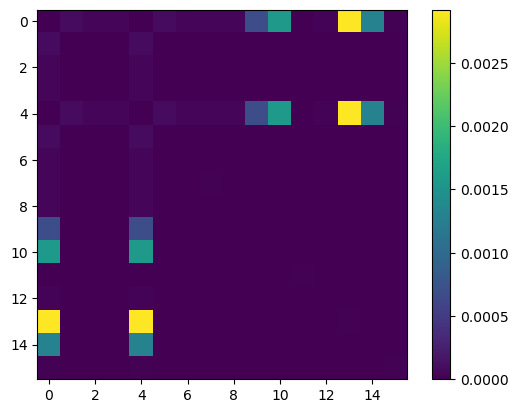

In [317]:
data = np.abs(chi_b)
data[data > 0.4] = 0
plt.imshow(data)
plt.colorbar()
plt.show()

In [348]:
H_b_full

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[-2.995964e-02  5.289977e-02  4.833791e+00 -5.219085e-02]
 [ 5.289977e-02  1.259072e-03  2.433859e-03  4.833860e+00]
 [ 4.833791e+00  2.433859e-03  1.428381e-02 -5.696388e-02]
 [-5.219085e-02  4.833860e+00 -5.696388e-02 -1.737493e-02]]

In [351]:
op_str = ["I", "X", "Y", "Z"]
op_list = [str1 + str2 for str1 in op_str for str2 in op_str]
op_list[13]

'ZX'

#### Carrier envelope

In [41]:
cost(
    traj.final_full_para | {"phase": 0.0},
    **{
        "which_qubit": 'b', "return_item": 'qt_infidelity',
})

(0.007041554297480985+0j)


0.7699090247168432

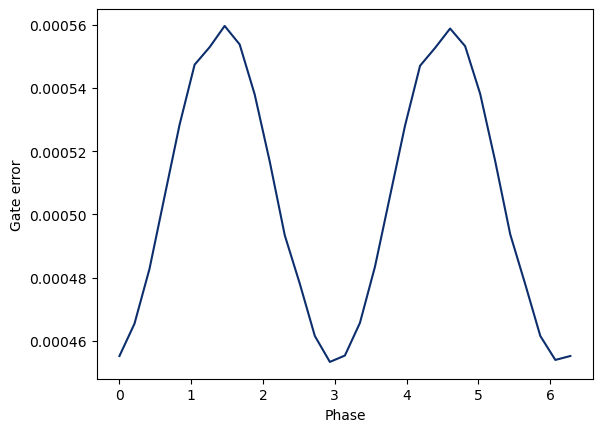

In [25]:
phase_list = np.linspace(0, 2*np.pi, 31)
gate_error_list = []
for phase in phase_list:
    gate_error_list.append(cost(
        traj.final_full_para | {"phase": phase, "target_phase": phase},
        **{
            "which_qubit": 'a', "return_item": 'qt_infidelity',
    }))

plt.plot(phase_list, gate_error_list)
plt.xlabel("Phase")
plt.ylabel("Gate error")
plt.show()

In [38]:
# freq_list = np.linspace(1.001, 1.003, 5)
# amp_list = np.linspace(0.0106, 0.0109, 5)
freq_list = np.linspace(1.00, 1.003, 10)
amp_list = np.linspace(0.0081, 0.008101, 5)

freq_mesh, amp_mesh = np.meshgrid(freq_list, amp_list, indexing='ij')
fidel_mesh = np.zeros_like(freq_mesh)
for idx in np.ndindex(freq_mesh.shape):
    freq = freq_mesh[idx]
    amp = amp_mesh[idx]
    fidel_mesh[idx] = (cost({"freq_factor": freq, "amp": amp, "phase": 0.0}, 'a', 
                            np.inf, np.inf, 
                            return_item='fidelity'))

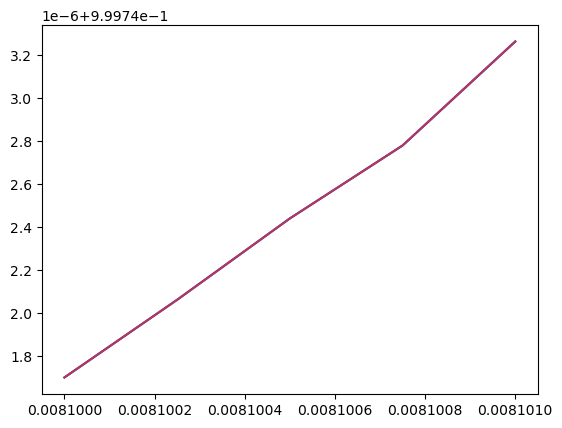

In [41]:
plt.plot(amp_mesh[0, :], fidel_mesh[0, :])
plt.show()

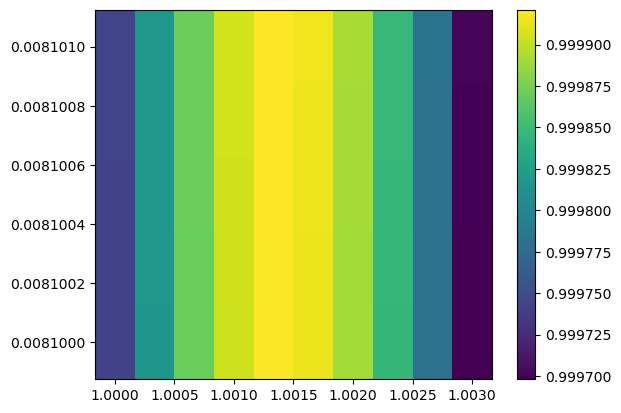

In [39]:
plt.pcolormesh(freq_mesh, amp_mesh, fidel_mesh)
plt.colorbar()

plt.show()

In [333]:
np.max(fidel_mesh)

0.9993370947269057

In [53]:
phase_list = np.linspace(-0.005, 0.005, 10)
fidel_list = []
for phase in phase_list:
    fidel_list.append(cost({"freq_factor": 1.00025, "amp": 0.00821, "phase": phase}, 'a', np.inf, np.inf, return_pop=False))

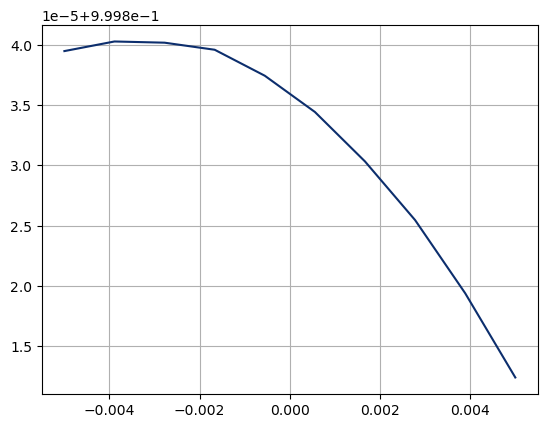

In [54]:
plt.plot(phase_list, fidel_list)
plt.grid()
plt.show()

## Simple test 

In [141]:
H = qt.Qobj(np.zeros((2,2)))
c_ops = [np.sqrt(1 / 2)*qt.sigmaz()]
tlist = np.linspace(0, 1, 100)

res = qt.mesolve(H, (qt.basis(2,0) + qt.basis(2,1)).unit(), tlist, c_ops, [qt.sigmax(), qt.sigmay(), qt.sigmaz()])

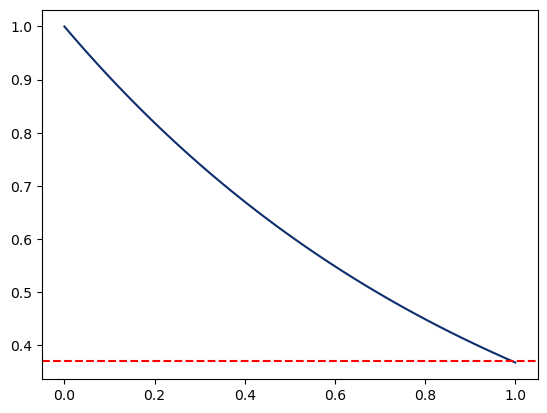

In [142]:
plt.plot(tlist, res.expect[0])
plt.axhline(y=1 / 2.7, color='r', linestyle='--')
plt.show()

In [ ]:
e